In [1]:
%matplotlib inline

import pandas as pd
import os
from pylab import savefig
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import decomposition
from sklearn.preprocessing import scale
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances
from sklearn import manifold
from matplotlib.collections import LineCollection

# PCA

    Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components (or sometimes, principal modes of variation)
    
- [Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis)


## Intuition

It can be thought of as fitting an ellipsoid to data where each axis corresponds to a Principal Component. The shorter the axis the less variance it is comprised of. [Visualization](https://www.joyofdata.de/public/pca-3d/)

## Singular value decomposition

$$X = U \Sigma W^t$$

## Explained Variance

    In case of PCA, "variance" means summative variance or multivariate variability or overall variability or total variability. Below is the covariance matrix of some 3 variables. Their variances are on the diagonal, and the sum of the 3 values (3.448) is the overall variability.
    
- [Stack Exchange](https://stats.stackexchange.com/questions/22569/pca-and-proportion-of-variance-explained)


By definition all the principal components have zero covariance, thus the total variance is the simple sum of variances (among components) and the explained variance is obtained simply by dividing each components variance by the sum of all.

# PCA - Excess Returns

## Auxiliar Functions

We will define some auxiliar functions that later on will be useful.

### max_dd

This function calculates the maximum drawdown. First it finds the maximum for the whole period, then it calculates the percentage difference of every point in time against the maximum. Lastly is selects the larger difference, thus returning the maximum drawdown

In [2]:
def max_dd(ser):
    max2here = ser.expanding(min_periods=1).max()
    dd2here = ser/max2here - 1.0
    return dd2here.min()

### GetPerformanceTable

This function creates a table for the ease of use.
First it cleans the `Excess Returns` data by dropping ou #N/A values.
Then it generates e cumulative return series based on a starting value = 100.
Lastly it performs several simple calculations storing it in the table's following columns:

* Excess Return - Annualized terms
* Volatility - Annualized terms
* Sharpe
* Sortino - Annualized terms
* Max drawdown
* Max Drawdown in Vol Terms
* 5th percentile in Vol Terms
* 10th percentile in Vol Terms

In [3]:
def GetPerformanceTable(ExcReturns, freq='Daily'):
    adju_factor = 252.0
    if freq=='Monthly':
        adju_factor = 12.0
    elif freq == 'Weekly':
        adju_factor = 52.0
 
    Table = pd.Series(index=['Excess Return','Volatility','Sharpe','Sortino','Max Drawdown',
                             'Max Drawdown in Vol Terms','5th percentile in Vol Terms','10th percentile in Vol Terms'])
 
    CleanIndexSeries = ExcReturns.dropna().sort_index()
 
    ER_index = pd.Series(index=CleanIndexSeries.index)
    ER_index[CleanIndexSeries.index[0]] = 100.0
    for d,d_minus_1 in zip(ER_index.index[1:],ER_index.index[:-1]):
        ER_index[d] = ER_index[d_minus_1]*(1+ExcReturns[d])
 
    Table['Excess Return'] = (ER_index.iloc[-1]/ER_index.iloc[0])**(adju_factor/(len(ER_index)-1.0))-1
    Table['Volatility'] = (np.log(ER_index).diff(1).dropna()).std()*np.sqrt(adju_factor)
    Table['Sharpe'] = Table['Excess Return']/Table['Volatility']
    Table['Sortino'] = Table['Excess Return']/(np.sqrt(adju_factor)*(np.log(ER_index).diff(1).dropna()[np.log(ER_index).diff(1).dropna()<0.0]).std())
    Table['Max Drawdown'] = max_dd(ER_index)
    Table['Max Drawdown in Vol Terms'] = max_dd(ER_index)/Table['Volatility']
    Table['5th percentile in Vol Terms'] = (ER_index.pct_change(1).dropna()).quantile(q=0.05)/Table['Volatility']
    Table['10th percentile in Vol Terms'] = (ER_index.pct_change(1).dropna()).quantile(q=0.1)/Table['Volatility']
    return Table

# Calculations

## Setup

First we create an Excel writer object so that the routine can write our results to an excel file.

[Documentation for pandas Excel Writer](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_excel.html)

In [4]:
writer = pd.ExcelWriter(os.path.join('','Results.xlsx'))

## Load Data

Now we load the data from an Excel file called `SeriesTemporaisHardcoded.xlsx` and manipulate it to create a single `DataFrame` with all the series:

In [5]:
file = 'SeriesTemporaisHardcoded.xlsx'

rawData = pd.read_excel(file, skiprows = 0, sheetname = None)

AllAssetClasses = pd.DataFrame()

for asset_class in rawData.keys():
    rawData[asset_class].set_index(rawData[asset_class].columns[0], inplace = True)
    rawData[asset_class].columns = [asset_class]
    rawData[asset_class].index.name = 'Dates'
    AllAssetClasses = pd.concat([AllAssetClasses, rawData[asset_class]]
                                ,join='outer',axis=1)

C:\Anaconda3\lib\site-packages\pandas\indexes\base.py:1877: FutureWarning: In the future, 'NAT < x' and 'x < NAT' will always be False.
  self._values[0] < other_diff[0]


The we transform all the series to `business month end frequency` according to the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/timeseries.html)

In [6]:
AllAssetClasses = AllAssetClasses.resample('BM').last()

Cut our sample to start only in 31-Dec-2006:

In [7]:
start_date = pd.to_datetime('31-Dec-2006')
AllAssetClasses = AllAssetClasses.loc[start_date:]

Write `AllAssetClasses` DataFrame to a sheet named `TR_Indices` in our results file

In [8]:
AllAssetClasses.to_excel(writer, 'TR_Indices')

Calculate and write the returns to the Results File

In [9]:
Returns = AllAssetClasses.pct_change(1)
Returns.to_excel(writer, 'TotalReturns')

Lastly we calculate the excess returns and the `PerformanceTable` (Function we wrote at the beggining) and write them to our results file in the sheets `ExcessReturns` and `ExcRetHist_summ`.

In [10]:
EReturns = pd.DataFrame()
Historical_Returns = pd.DataFrame()

for asset_class in Returns.drop('CDI',axis=1).columns:
    EReturns[asset_class] = Returns[asset_class] - Returns['CDI']
    asset_stats = GetPerformanceTable(EReturns[asset_class].dropna(),freq='Monthly')
    Historical_Returns = pd.concat([Historical_Returns, asset_stats.to_frame(asset_class)], join='outer', axis=1)
 
EReturns.to_excel(writer, 'ExcessReturns')
Historical_Returns.to_excel(writer, 'ExcRetHist_summ')
writer.save()

# Plots

## Bubble Plot

We create a bubble plot in which the x-axis corresponds to `Volatility`, the y-axis corresponds to `Excess Returns` and the bubble size corresponds to the `Sharpe Index` values


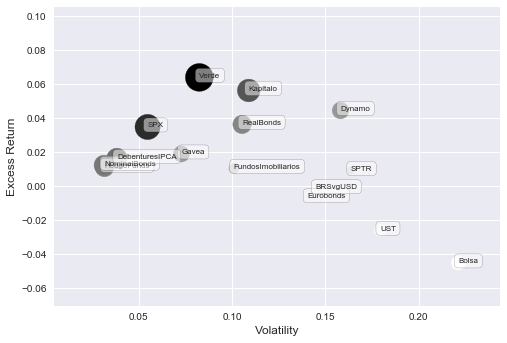

In [11]:
plt.scatter(Historical_Returns.loc['Volatility'].values,
            Historical_Returns.loc['Excess Return'].values,
            s=1000.0*np.abs(Historical_Returns.loc['Sharpe'].values),c=Historical_Returns[EReturns.columns].loc['Sharpe'].values)
for label, x, y in zip(Historical_Returns.columns, Historical_Returns.loc['Volatility'].values, Historical_Returns.loc['Excess Return'].values):
    plt.annotate(label,xy=(x, y), bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.50),size=8)
plt.xlabel('Volatility', fontsize=12)
plt.ylabel('Excess Return', fontsize=12)
# savefig(os.path.join(pathname,'bubblechart.png'))
 

## Pair Plot

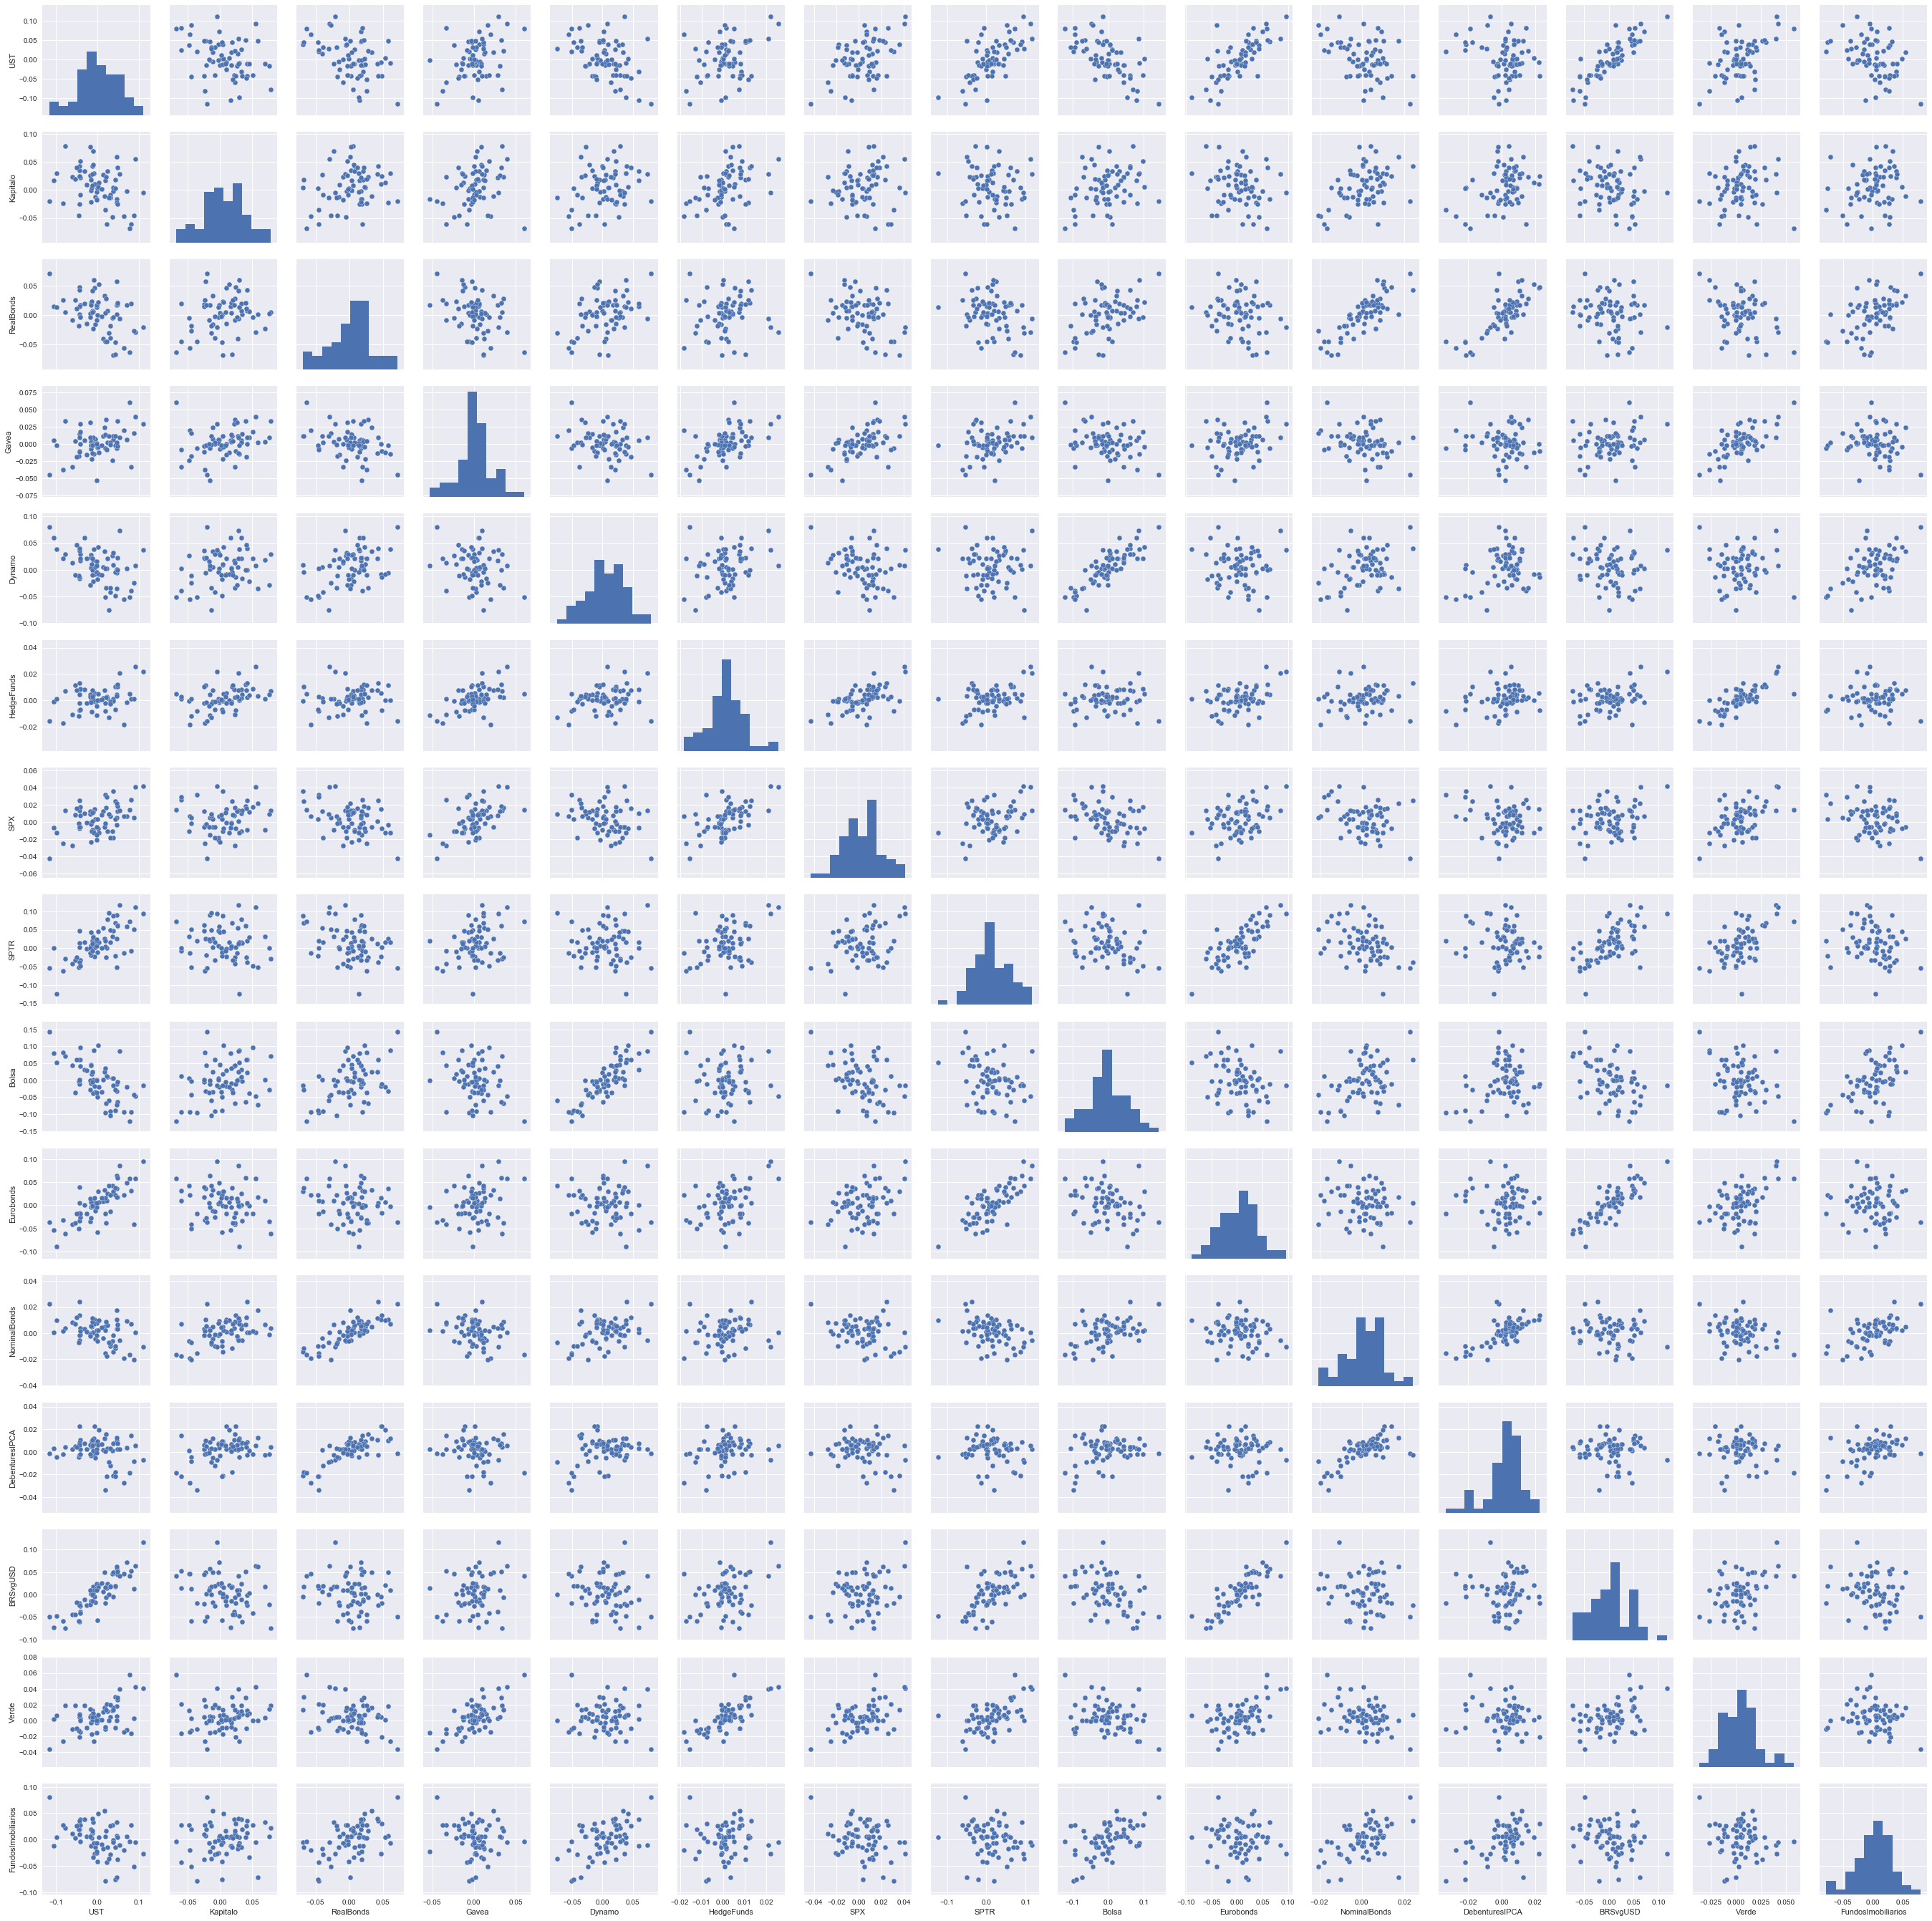

In [14]:
sns.pairplot(EReturns.dropna(how='any'))
# savefig(os.path.join(pathname,'pairplot.png'))
 
# plt.figure(1, figsize=(4, 3))
# plt.clf()
# plt.axes([.2, .2, .7, .7])

## Dendogram

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'b'],
 'dcoord': [[0.0, 0.023227983789575135, 0.023227983789575135, 0.0],
  [0.0, 0.031660359359597545, 0.031660359359597545, 0.023227983789575135],
  [0.0, 0.043474267433906588, 0.043474267433906588, 0.031660359359597545],
  [0.0, 0.081585168816580178, 0.081585168816580178, 0.0],
  [0.0, 0.1054910517088351, 0.1054910517088351, 0.081585168816580178],
  [0.0, 0.12072600327625449, 0.12072600327625449, 0.1054910517088351],
  [0.043474267433906588,
   0.18123754186687058,
   0.18123754186687058,
   0.12072600327625449],
  [0.0, 0.022668152006312448, 0.022668152006312448, 0.0],
  [0.0, 0.047969286534140787, 0.047969286534140787, 0.022668152006312448],
  [0.0, 0.027262240406621174, 0.027262240406621174, 0.0],
  [0.0, 0.11462288937719944, 0.11462288937719944, 0.027262240406621174],
  [0.047969286534140787,
   0.14043422438164044,
   0.14043422438164044,
   0.11462288937719944],
  [0.0, 0

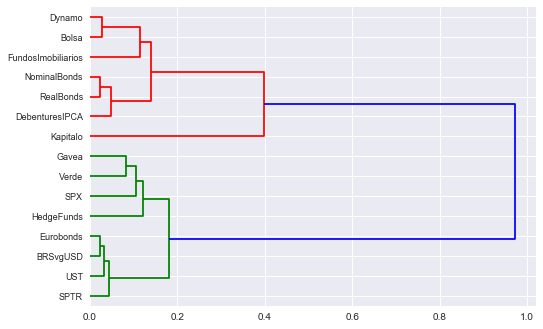

In [13]:
Z=sch.linkage(EReturns.dropna(how='any').corr(), 'single', 'correlation')
sch.dendrogram(Z, color_threshold=0.5,labels=EReturns.columns,orientation='right',leaf_font_size=9)
# savefig(os.path.join(pathname,'dendrogram.png'))

## Other applications of clustering methods
 
 * Sequence analysis
 * Market research to partition data from surveys
 * Marketing : grouping several itens in one product (ebay)
 * Image segmentation 
 * Outliers detection
 * Sound decomposition

# PCA Decomposition

First we separate Hedge Funds from other assets and use only the other assets.

Then we pass this data to the `sklearn` package's decomposition module.

In [14]:
AllAssetExcessReturns = EReturns.copy()
hedge_funds = ['Verde','Gavea','SPX','Dynamo','Kapitalo','HedgeFunds']
no_hedge_funds = [asset for asset in EReturns.columns if asset not in hedge_funds]
EReturns = EReturns[no_hedge_funds]
 
pca = decomposition.PCA()
pca.fit(EReturns.dropna(how='any'))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The we plot the explained variance for each of the decomposed factors (bars) and the cumulative explained variance (line)

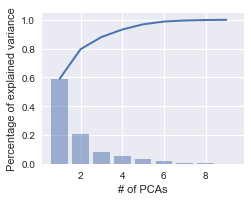

In [15]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
 
cumm_explained_variance = [pca.explained_variance_[0]]
for i in range(1,len(pca.explained_variance_)):
    cumm_explained_variance.append(cumm_explained_variance[i-1] + pca.explained_variance_[i])
 
plt.plot(range(1,len(pca.explained_variance_)+1),cumm_explained_variance/np.sum(pca.explained_variance_), linewidth=2)
plt.bar(range(1,len(pca.explained_variance_)+1), pca.explained_variance_/np.sum(pca.explained_variance_), align='center', alpha=0.5)
plt.axis('tight')
plt.xlabel('# of PCAs')
plt.ylabel('Percentage of explained variance')
# savefig(os.path.join(pathname,'PCA.png'))

## Last Plot

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide


NameError: name 'pathname' is not defined

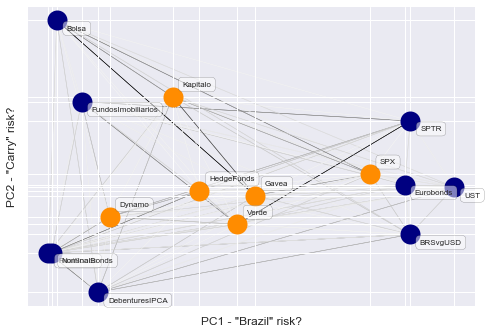

In [16]:

# Rotate the data
CORR = EReturns.dropna(how='any').corr().values
clf = decomposition.PCA(n_components=2)
CORR = clf.fit_transform(CORR)
NEW_ASSET_CORR = clf.fit_transform(AllAssetExcessReturns.corr()[no_hedge_funds].loc[hedge_funds].values)
 
fig, ax = plt.subplots()
fig.subplots_adjust(wspace=0)
plt.plot(CORR[:, 0], CORR[:, 1],'o',color='navy',ms=20)
plt.plot(NEW_ASSET_CORR[:, 0], NEW_ASSET_CORR[:, 1],'o',color='darkorange',ms=20,)
 
for label, x, y in zip(EReturns.columns, CORR[:, 0], CORR[:, 1]):
    plt.annotate(label,xy=(x, y), xytext=(10, -10), textcoords='offset points',size=8,
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
 
for label, x, y in zip(hedge_funds, NEW_ASSET_CORR[:, 0], NEW_ASSET_CORR[:, 1]):
    plt.annotate(label,xy=(x, y), xytext=(10, 10), textcoords='offset points',size=8,
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
 
# Plot the edges
CORR = np.concatenate((CORR,NEW_ASSET_CORR))
distance_matrix = euclidean_distances(AllAssetExcessReturns[hedge_funds + no_hedge_funds].dropna(how='any').corr().values)
similarities = distance_matrix.max() / distance_matrix * 100
similarities[np.isinf(similarities)] = 0
 
start_idx, end_idx = np.where(CORR)
segments = [[CORR[i, :], CORR[j, :]]
            for i in range(len(CORR)) for j in range(len(CORR))]
values = np.abs(similarities)
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Greys,
                    norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(0.5 * np.ones(len(segments)))
ax.add_collection(lc)
 
plt.xticks(CORR[:, 0]," ")
plt.yticks(CORR[:, 1]," ")
plt.xlabel('PC1 - "Brazil" risk?', fontsize=12)
plt.ylabel('PC2 - "Carry" risk?', fontsize=12)
# fig.savefig(os.path.join(pathname,'ProjectionPCASpace.png'))